In [2]:
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import YamlIO as Yaml
import matplotlib.pyplot as plt
import numpy as np

# Analysis of the $CO$ molecule in a static electric field

We consider a $CO$ molecule (oriented along the $z$-axis) in a static electric field. We present results for fields both directed in the z (axial) and in the x directions. 
The main aim of this analysis is to compute the statical polarizability of the molecule and check its convergence w.r.t. the size of the simulation domain

## System definition and computations

In [3]:
outputpath = 'CO/static-field/'

We define the python dictionary that contains the basic keys common to all the file in the run

In [4]:
inp0 = {'dft' : 
        {'hgrids': 0.37,
         'gnrm_cv' : 1e-8,
         'itermax' : 100},
        'posinp': 'CO_posinp.xyz'}
Yaml.dump(inp0,outputpath + 'default.yaml')

We perform the analysis for different box sizes and for the field norm equal to 0.0 and 1e-2 (a.u.) both in the z and x direction. 
We build python dictionary with the structure 

CO['field direction']['field norm']['box size']

In [5]:
enorm = [0.0,1e-2]
rVal = [float(i) for i in range(4,11)]

In [6]:
CO = {'x':{}, 'z':{}}
for e in enorm:
    ex=[e,0.0,0.0]
    ez=[0.0,0.0,e]
    CO['x'][e] = {}
    CO['z'][e] = {}
    for r in rVal:
        box = [r,9.0]
        CO['x'][e][r] = {'input' : {'dft':{'rmult':box,'elecfield':ex}}} 
        CO['z'][e][r] = {'input' : {'dft':{'rmult':box,'elecfield':ez}}}

In [7]:
CO['x'][0.01][7.0]['input']

{'dft': {'elecfield': [0.01, 0.0, 0.0], 'rmult': [7.0, 9.0]}}

In [8]:
study = C.SystemCalculator(omp='2',mpi_run='mpirun -np 4')

Initialize a Calculator with OMP_NUM_THREADS=2 and command mpirun -np 4 /home/marco/Applications/BigDFT/binaries/v1.8.3/install/bin/bigdft


In [9]:
%cd $outputpath
for edir in ['x','z']:
    for e in enorm:
        for r in rVal:
            inpName = 'E'+str(edir)+'_enorm_'+str(e)+'_rmult_'+str(r)
            CO[edir][e][r]['log'] = study.run(name=inpName,input=CO[edir][e][r]['input'],outdir='./log/',skip=True)
%cd ../../

/home/marco/Data/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper/CO/static-field
Creating the yaml input file "./Ex_enorm_0.0_rmult_4.0.yaml"
Executing command:  mpirun -np 4 /home/marco/Applications/BigDFT/binaries/v1.8.3/install/bin/bigdft -n Ex_enorm_0.0_rmult_4.0 -d ./log/ -s Yes
Creating the yaml input file "./Ex_enorm_0.0_rmult_5.0.yaml"
Executing command:  mpirun -np 4 /home/marco/Applications/BigDFT/binaries/v1.8.3/install/bin/bigdft -n Ex_enorm_0.0_rmult_5.0 -d ./log/ -s Yes
Creating the yaml input file "./Ex_enorm_0.0_rmult_6.0.yaml"
Executing command:  mpirun -np 4 /home/marco/Applications/BigDFT/binaries/v1.8.3/install/bin/bigdft -n Ex_enorm_0.0_rmult_6.0 -d ./log/ -s Yes
Creating the yaml input file "./Ex_enorm_0.0_rmult_7.0.yaml"
Executing command:  mpirun -np 4 /home/marco/Applications/BigDFT/binaries/v1.8.3/install/bin/bigdft -n Ex_enorm_0.0_rmult_7.0 -d ./log/ -s Yes
Creating the yaml input file "./Ex_enorm_0.0_rmult_8.0.yaml"
Executing command:  mpirun -np 4 /ho

For instance to extract the z dimension of the simulation box in Angstroem

In [10]:
CO['x'][0.01][7]['log'].log['Sizes of the simulation domain']['Angstroem'][2]

11.552

### Convergence of the statical polarizability w.r.t the box size

Compute the statical polarizability (as the ratio between the induced dipole minus the permament one divided for the value of the field) in each simulation box and check of the convergence of the result 

In [11]:
alpha = {'x': {}, 'z': {}}
dipoleGS = {'x': {}, 'z': {}}
for r in rVal:
    dipGSX = CO['x'][enorm[0]][r]['log'].log['Electric Dipole Moment (AU)']['P vector'][0]
    indipoleX = CO['x'][enorm[1]][r]['log'].log['Electric Dipole Moment (AU)']['P vector'][0]
    dipGSZ = CO['z'][enorm[0]][r]['log'].log['Electric Dipole Moment (AU)']['P vector'][2]
    indipoleZ = CO['z'][enorm[1]][r]['log'].log['Electric Dipole Moment (AU)']['P vector'][2]
    alpha['x'][r] = (indipoleX-dipGSX)/enorm[1]
    alpha['z'][r] = (indipoleZ-dipGSZ)/enorm[1]
    dipoleGS['x'][r] = np.abs(dipGSX)
    dipoleGS['z'][r] = np.abs(dipGSZ)
boxSize = []
for r in rVal:
    boxSize.append(CO['x'][0.0][r]['log'].log['Sizes of the simulation domain']['Angstroem'][2])    

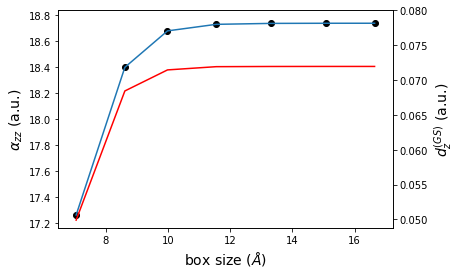

In [12]:
%matplotlib inline

fig, ax1 = plt.subplots()

ax1.set_xlabel('box size ($\AA$)',size = 14)
plt.ylabel(r'$\alpha_{zz}$ (a.u.)',size = 14)
ax1.plot(boxSize,alpha['z'].values())
for ind,r in enumerate(rVal):
    ax1.scatter(boxSize[ind],alpha['z'][r],color='black')

ax2 = ax1.twinx()
ax2.plot(boxSize,dipoleGS['z'].values(),color='red',linestyle='-')
#plt.yticks([])
plt.ylim(ymax=0.08)
plt.ylabel(r'$d_z^{(GS)}$ (a.u.)',size=14)
plt.show()